In [1]:
import os
os.chdir('d:/future/Index_Future_Prediction')

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from scipy.stats import norm, t

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import display, Markdown

In [3]:
from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain
from utils.get_ohlcv import GetOHLCV

In [4]:
import tushare as ts
pro = ts.pro_api('700c1d6015ad030ff20bf310c088243da030e6b79a2a1098d58d2614')

In [5]:
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'FU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
assets_list = ['IH.CFX']

In [6]:
seq_len = 5
pred_len = 5
train_ratio = 0.5
validation_ratio = 0.2
test_ratio = 0.03
threshold_ratio = 0.25
hidden_size = 10
num_layers = 1

In [7]:
def get_random_split(train_ratio, validation_ratio, test_ratio):
    source = GetOHLCV()
    sample_date = source.get_data('M.DCE', 5, 0.3)
    date_column = sample_date['trade_date'].copy()
    total_size = len(date_column)
    train_size = int(train_ratio * total_size)
    validation_size = int(validation_ratio * total_size)
    test_size = int(test_ratio * total_size)
    random_split = np.random.randint(train_size, total_size - validation_size - test_size)
    validation_start = date_column.iloc[random_split]
    test_start = date_column.iloc[random_split+validation_size]
    test_end = date_column.iloc[random_split+validation_size+test_size]
    return validation_start, test_start, test_end

In [8]:
source = GetOHLCV()
data = source.get_data('IH.CFX', 5, 0.25)
data

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,...,label_pred_low,label_amplitude,label_amplitude_ma,label_std,upper_bond,lower_bond,threshold,down_prob,middle_prob,up_prob
414,IH.CFX,20160422,2136.4,2149.6,2123.4,2154.0,2121.2,2147.8,2146.2,-1.8,...,2111.4,53.2,212.6544,5.670173,2.378441,-3.703517,3.040979,0.365132,0.401515,0.233353
413,IH.CFX,20160425,2147.8,2146.2,2139.0,2143.0,2111.4,2136.8,2137.0,-9.4,...,2113.6,51.4,212.0416,5.671164,2.378441,-3.703517,3.040979,0.246429,0.404069,0.349502
412,IH.CFX,20160426,2136.8,2137.0,2142.4,2164.6,2125.2,2141.4,2137.0,4.4,...,2113.6,51.4,211.4272,5.652634,2.340431,-3.703517,3.021974,0.274608,0.406319,0.319073
411,IH.CFX,20160427,2141.4,2137.0,2147.2,2149.8,2122.8,2131.6,2133.0,-5.4,...,2113.6,51.4,210.8088,5.651296,2.340431,-3.703517,3.021974,0.256065,0.404482,0.339454
410,IH.CFX,20160428,2131.6,2133.0,2140.8,2142.8,2119.6,2124.6,2128.2,-8.4,...,2091.2,73.8,210.2800,5.651401,2.340431,-3.703517,3.021974,0.399613,0.392883,0.207504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,IH.CFX,20250916,2962.4,2961.2,2968.2,2975.8,2942.4,2950.6,2950.4,-10.6,...,2888.4,87.6,106.8576,3.284237,1.445473,-0.978616,1.212044,0.458696,0.278387,0.262917
673,IH.CFX,20250917,2950.6,2950.4,2951.2,2962.6,2935.0,2956.2,2953.6,5.8,...,2888.4,87.6,106.8872,3.278371,1.445473,-0.970611,1.208042,0.421211,0.283563,0.295226
672,IH.CFX,20250918,2956.2,2953.6,2965.6,2976.0,2888.4,2910.8,2907.8,-42.8,...,2889.0,76.0,106.9792,3.272989,1.448386,-0.962091,1.205239,0.207761,0.261257,0.530983
671,IH.CFX,20250919,2910.8,2903.4,2917.4,2932.0,2904.4,2913.4,2917.4,10.0,...,2889.0,76.0,107.1296,3.272237,1.448386,-0.962091,1.205239,0.244538,0.273355,0.482107


In [9]:
def get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio):

    source = GetOHLCV()

    train_set = None
    validation_set = None
    test_set = None
    feature_column = ['log_open','log_high','log_low','log_close','log_amount']
    label_column = ['label_return','down_prob','middle_prob','up_prob']
    
    for code in assets_list:

        data = source.get_data(code, pred_len, threshold_ratio)

        train_data = data[data['trade_date'] < validation_start].copy()
        validation_data = data[(data['trade_date'] >= validation_start) & (data['trade_date'] < test_start)].copy()
        test_data = data[(data['trade_date'] >= test_start) & (data['trade_date'] < test_end)].copy()
    
        train_feature = torch.tensor(train_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        train_feature = train_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)

        validation_feature = torch.tensor(validation_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        validation_feature = validation_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)

        test_feature = torch.tensor(test_data[feature_column].values, dtype = torch.float32, device = 'cuda:0')
        test_feature = test_feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(1,2)



        train_label = torch.tensor(train_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        train_label = train_label[seq_len-1:]

        validation_label = torch.tensor(validation_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        validation_label = validation_label[seq_len-1:]

        test_label = torch.tensor(test_data[label_column].values, dtype = torch.float32, device = 'cuda:0')
        test_label = test_label[seq_len-1:]



        if train_set == None:
            train_set = CallableDataset(train_feature, train_label)
        else:
            train_set = train_set + CallableDataset(train_feature, train_label)

        if validation_set == None:
            validation_set = CallableDataset(validation_feature, validation_label)
        else:
            validation_set = validation_set + CallableDataset(validation_feature, validation_label)
        
        if test_set == None:
            test_set = CallableDataset(test_feature, test_label)
        else:
            test_set = test_set + CallableDataset(test_feature, test_label)

    return train_set, validation_set, test_set

In [10]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


In [11]:
class Baseline_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, hidden_size, num_layers, dropout, **kwargs):
        super(Baseline_LSTM, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.process = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.regularization = nn.Sequential(nn.Flatten(),nn.Dropout(dropout))
        self.output = HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.5,0.0])

    def forward(self, x):
        #为了提升模型的泛化能力，我们每次输入都随机舍弃一部分前端的序列
        if self.training:
            seq_len = x.shape[1]
            random_drop = np.random.randint(0, seq_len//2)
            x = x[:,random_drop:,:] 

        return self.output(self.process(x)[0][:,-1,:])

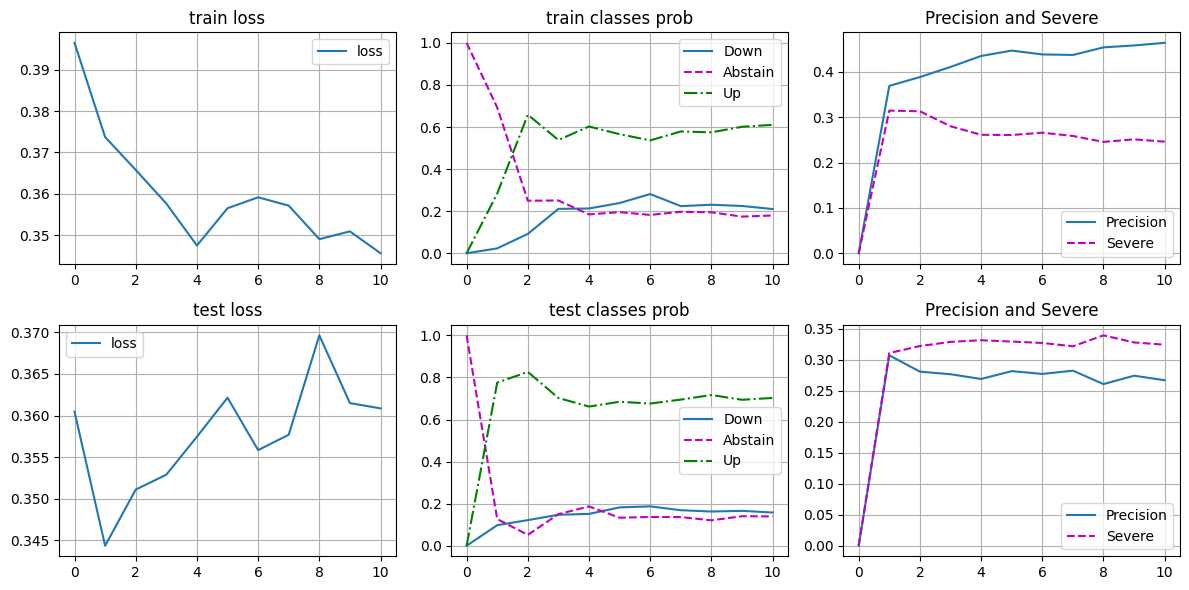

 37%|███▋      | 37/100 [00:10<00:00, 366.18it/s]

In [ ]:
result = np.zeros(shape = (10, len(assets_list), 4))

for i in range(10):
    validation_start, test_start, test_end = get_random_split(train_ratio, validation_ratio, test_ratio)
    # train_set, validation_set, test_set = get_data_set(assets_list, validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio)
    print(validation_start, test_start, test_end)

    for j in range(len(assets_list)):
        code = assets_list[j]
        train_set_2, validation_set_2, test_set_2 = get_data_set([code], validation_start, test_start, test_end, seq_len, pred_len, threshold_ratio)

        model = Baseline_LSTM(input_size = 5, hidden_size = hidden_size, num_layers = num_layers, dropout = 0.5).to('cuda:0')
        loss_fn = HybridLoss(alpha = 1e-1, delta = 1)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        train = ModelTrain(model = model,
                        batch_size = 100,
                        train_set = train_set_2,
                        validation_set = validation_set_2,
                        test_set = test_set_2,
                        loss_fn = loss_fn,
                        optimizer = optimizer,
                        scheduler=scheduler,
                        recorder=recorder,
                        graph=animator,
                        )
        
        # train.train_set = train_set
        # train.validation_set = validation_set_2

        # prediction, precision = train.epoch_train(epochs = 5, round = 100, early_stop = 10)
        # result[i,j,0] = prediction
        # result[i,j,1] = precision

        train.train_set = train_set_2
        train.validation_set = validation_set_2

        prediction, precision = train.epoch_train(epochs = 10, round = 100, early_stop = 100)
        result[i,j,2] = prediction
        result[i,j,3] = precision

In [ ]:
all_assets = pd.DataFrame({
    'stage_1_prediction': np.mean(result, axis = 0)[:,0],
    'stage_2_prediction': np.mean(result, axis = 0)[:,2],

    'stage_1_precision': np.mean(result, axis = 0)[:,1],
    'stage_2_precision': np.mean(result, axis = 0)[:,3],

    'stage_1_precision_std': np.std(result, axis = 0)[:,1],
    'stage_2_precision_std': np.std(result, axis = 0)[:,3],
})
all_assets.index = pd.Series(assets_list)
for col in all_assets.columns:
    all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")
    
markdown_table = all_assets.to_markdown(index=False)
print(f'hidden_size: {hidden_size}, num_layers: {num_layers}, seq_len: {seq_len}')
print(markdown_table)

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 0.0%                 | 79.1%                | 0.0%                | 0.2%                | 0.0%                    | 8.9%                    |
